# Test Visuals for Power BI

In [1]:
import numpy as np
import pandas
import seaborn as sns
import matplotlib
import csv

## Get tables from DB

In [3]:
from util.db import *
laboredge = get_table_pd("SELECT * FROM import.tempServices")

# case_supplier = get_table_pd("SELECT s.Name, cc.Case_Contract_Text__c, cc.Id FROM SFDC.Case_Contract AS cc FULL JOIN SFDC.Supplier AS s ON (s.Id = cc.Supplier__c)")
# case_supplier.rename(columns = {'name':'supplier_name'}, inplace=True)

### merge to get supplier names

In [4]:
#dataset = laboredge.merge(case_supplier, left_on="object_x_id", right_on="id", how="left")
dataset = laboredge

In [5]:
dataset.columns

Index(['idxdntneed', 'input_date', 'object_x_id', 'oem_company',
       'product_category', 'level', 'position_title', 'hours',
       'years_exp_high', 'years_exp_low', 'quoted_rate_high',
       'quoted_rate_low', 'cep_provided_rate_high', 'cep_provided_rate_low',
       'deal_total', 'country', 'city_state', 'currency_notes',
       'document_name', 'database_practice'],
      dtype='object')

### get unique case nums for rows with quoted low and quoted high

In [122]:
from util.nlp import write_list_csv

In [131]:
laborxl = pandas.read_excel(r"C:\Users\RossMarino\Downloads\le.xlsx", header=1)

In [133]:
laborxl.columns

Index(['Deal Date', 'Case #', 'Client', 'Service Provider', 'OEM Company',
       'Product/Category', 'Level', 'Position Title', 'Hours', 'Low', 'High',
       'Country', 'City/State', 'Low.1', 'High.1', 'Low.2', 'High.2',
       'Deal Total', 'Currency Notes', 'Document Name', 'Unnamed: 20'],
      dtype='object')

In [136]:
high_cases = list(set(laborxl[laborxl['High.1'].notnull()]['Case #']))
len(high_cases)

110

In [137]:
write_list_csv('cases_high.csv',high_cases)

### rename col for Power BI

In [7]:
laboredge.rename(columns={'quoted_rate_low':'Quoted Rate Low',
               'quoted_rate_high':'Quoted Rate High',
               'cep_provided_rate_low': 'CEP Provided Rate Low',
               'cep_provided_rate_high':'CEP Provided Rate High',
               'hours':'Hours',
               'supplier_name':'Service Provider'}, inplace=True)

## Box and Whisker

settings from Power BI

In [41]:
import uuid

In [39]:
matplotlib.pyplot.figure(figsize=(5.55555555555556,4.16666666666667), dpi=72)
matplotlib.pyplot.show = lambda args=None,kw=None: matplotlib.pyplot.savefig(str(uuid.uuid1()))

<Figure size 400x300 with 0 Axes>

Subset Data that is going to be used in Visual

In [46]:
dataset = laboredge[['Quoted Rate Low','Quoted Rate High', 'CEP Provided Rate Low','CEP Provided Rate High']].astype('float')

### Copy and Paste below

Test when one column all NA's

#dataset = dataset[dataset['CEP Provided Rate High'].isnull()].sample(n=1000, random_state=42)

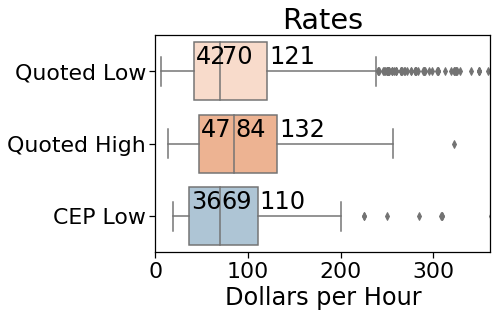

In [51]:
import numpy as np
import seaborn as sns

dataset.dropna(axis=1,how='all',inplace=True)
dataset.rename(columns={'Quoted Rate Low':'Quoted Low',
                       'Quoted Rate High':'Quoted High',
                       'CEP Provided Rate Low': 'CEP Low',
                       'CEP Provided Rate High':'CEP High'}, inplace=True)
##################################################
# Reformat rates to variable/value
# Calculate quantiles for labelling
rates_melted = pandas.melt(dataset, 
                       value_vars=dataset.columns)
rates_melted = rates_melted[rates_melted.value.notnull()]

quants = dataset.quantile([0.25,0.5,0.75])

##################################################
# Set options for the figure
mycolors = ['#ffd9c4','#fcaf83','#a8c6db','#6ea4ca'] # light orange, orange, light blue, blue (of CEP.com)
max_x = np.max(np.max(quants))*2.75
sns.set_context('notebook',font_scale=2)
matplotlib.pyplot.xlim(0,max_x)

##################################################
# Draw graph
bp = sns.boxplot(x="value", y="variable", data=rates_melted, palette=mycolors)

#Label using quants
i = 0
for col in quants.columns:
    for qu in quants[col]:
        matplotlib.pyplot.text(x = qu+2, y = i-0.1, s = "{:.0f}".format(qu))
    i += 1

matplotlib.pyplot.title('Rates', fontsize='large')
matplotlib.pyplot.xlabel('Dollars per Hour')
matplotlib.pyplot.ylabel('')
matplotlib.pyplot.show()

## Rate by Hours

In [15]:
labor_nahours=laboredge[laboredge.hours.notnull() & laboredge.quoted_rate_low.notnull()]

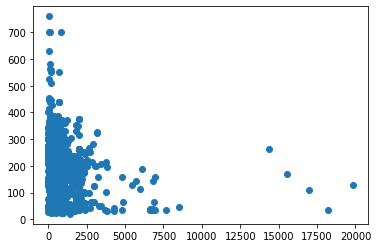

In [17]:
matplotlib.pyplot.scatter(np.array(labor_nahours.hours),np.array(labor_nahours.quoted_rate_low))

## IQR Mean

In [256]:
means = [] 
for col in quants.columns:
    temp_mask = (dataset[col]>quants[col][0.25]) & (dataset[col]<quants[col][0.75])
    mn = np.mean(dataset[col][temp_mask])
    means.append(['{:.2f}'.format(mn)])

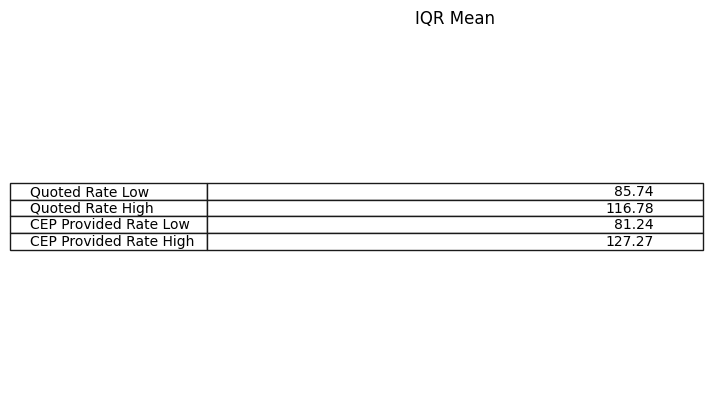

In [264]:
fig, ax = matplotlib.pyplot.subplots() 

ax.set_axis_off()
ax.set_title('IQR Mean')
ax.table(cellText=means, rowLabels=list(quants.columns), loc='center')


## Table Visual 

In [194]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [165]:
rate_sum = dataset[['Quoted Rate Low','Quoted Rate High', 'CEP Provided Rate Low','CEP Provided Rate High']].describe()

In [174]:
col_names = list(rate_sum.columns)
row_names = list(rate_sum.index)

Quoted Rate Low           23538.0
Quoted Rate High           2220.0
CEP Provided Rate Low     15775.0
CEP Provided Rate High    15162.0
Name: count, dtype: float64

In [187]:
cell_nums = []
for i,r in rate_sum.iterrows():
    temp_a = []
    for ea in r:
        temp_a.append("{:.2f}".format(ea))
    cell_nums.append(list(temp_a))


In [254]:
cell_nums

[['23538.00', '2220.00', '15775.00', '15162.00'],
 ['114.09', '140.69', '105.01', '152.43'],
 ['100.01', '106.68', '89.50', '115.21'],
 ['5.00', '11.00', '3.00', '15.00'],
 ['42.00', '65.00', '34.00', '56.25'],
 ['84.46', '110.00', '75.00', '120.00'],
 ['150.00', '190.00', '155.00', '225.00'],
 ['2000.00', '1150.00', '1160.00', '1600.00']]

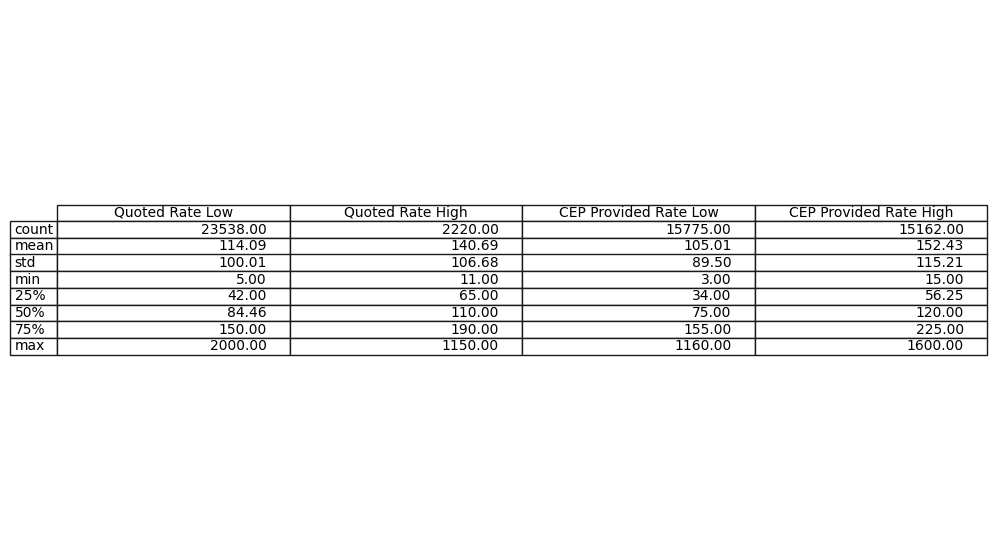

In [202]:
fig, ax = matplotlib.pyplot.subplots(figsize=(12,7)) 

ax.set_axis_off()
ax.axis('tight')
ax.table(cellText=cell_nums,
                      rowLabels=row_names,
                      colLabels=col_names,
                       loc = "center")